In [10]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [47]:
import numpy as np
import pandas as pd
import scipy.stats as sts
import matplotlib.pyplot as plt
import random as rd
import geopandas as gpd
import matplotlib
import numpy as np
%matplotlib inline
import pylab


In [2]:
#https://data.world/dcopendata/abbccdba911a4610a60aab68a2a77328-5

file = gpd.read_file("Floodplain_Base_Flood_Elevations.dbf")
data = pd.DataFrame(file)
data.head()

,OBJECTID,BFE_LN_ID,ELEV,LEN_UNIT,V_DATUM,SOURCE_CIT,SHAPE_Leng,DFIRM_ID,VERSION_ID,geometry
0,1,110001_1863615,103,Feet,NAVD88,110001_STUDY1,35.618069,110001,1.1.1.0,None
1,2,110001_1863292,81,Feet,NAVD88,110001_STUDY1,65.850577,110001,1.1.1.0,None
2,3,110001_1863178,87,Feet,NAVD88,110001_STUDY1,207.770721,110001,1.1.1.0,None
3,4,110001_1863629,63,Feet,NAVD88,110001_STUDY1,133.515113,110001,1.1.1.0,None
4,5,110001_1862867,73,Feet,NAVD88,110001_STUDY1,79.503273,110001,1.1.1.0,None


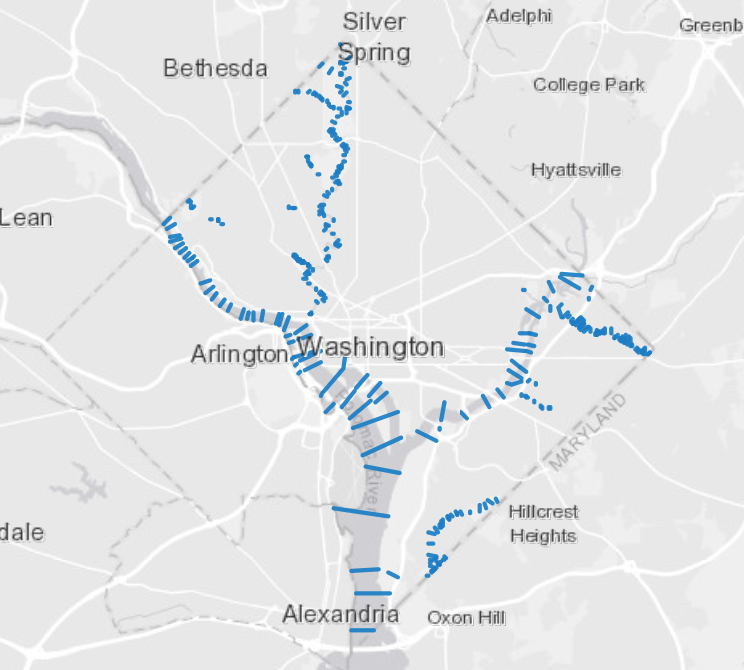

In [3]:
from IPython.display import Image
Image("washington.png")

In [4]:
elev = data['ELEV'].values[0:400]
elev = elev.reshape(20, 20)

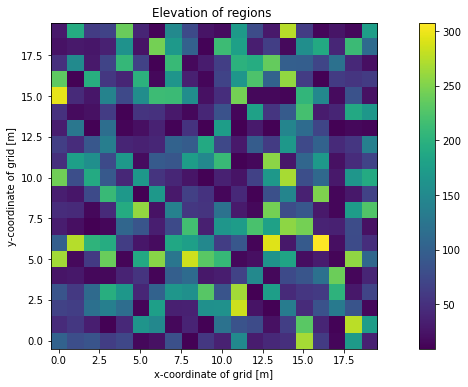

In [48]:
plt.figure(figsize=(15, 6))
plt.title('Elevation of regions ')
plt.xlabel('x-coordinate of grid [m]')
plt.ylabel('y-coordinate of grid [m]')
plt.imshow(elev, origin='lower')
plt.colorbar()
plt.show()

### A Cell Class
simulates and updated the behavior of each cell. Is necessary for contatining attributes of each cell, like elevation levels and probability of flooding

In [166]:
sts.norm(-1, 0.4).pdf(0)

0.043820751233921346

In [159]:

class Cell:
    """
    input:
        elevation: int - elevation of the land relative to sea level 
        recovery: rat of recovery of the cell. This reflects the reduction in the water level of the cell
    """
    
    def __init__(self, elevation, recovery):
        self.elevation = elevation
        self.recovery = recovery 
        self.level = sts.norm.rvs(-1, 0.4)
        self.flood = False
        self.waterlogged = False
        self.total = self.elevation + self.level

    def reduce(self):
        self.level = self.level - self.level*(self.recovery) 
 
    def update(self, rain):
        self.waterlogged = False
        self.flood = False
        self.rain = rain
        self.level += self.rain    
        if self.level > 0:
            self.flood = True
        elif self.level == 0:
            self.waterlogged = True
        self.reduce()
        
    
    

### Simulation class 
generates an array of cell that can follow a system wide updating rules and be visualized in a grid.

In [187]:
class Simulation:
    """
    inputs:
        elevation_grid: 2D array of the elevation of different regions
        p: int (0-1) - probability of rain  
        r: float - average recovery rate of a cell 
        avg_rain_amount: float - average rain per day in meters 

    """
    def __init__(self, elevation_grid, p, r, avg_rain_amount):
        self.elevation_grid = elevation_grid
        self.r = r
        self.neighbor = 0
        self.transfer = []
        self.n = len(self.elevation_grid)
        self.avg_rain = avg_rain_amount
        self.p = p
        self.water_grid = np.zeros((self.n, self.n))
        self.cells = []  #a list of cell objects 
        for i in range(self.n):
            row = []
            for j in range(self.n):
                c = Cell(self.elevation_grid[i][j], sts.norm.rvs(r, 0.04))
                row.append(c)
            self.cells.append(row)
            
    def grid(self, attribute):
        cell_list = np.array(self.cells).flatten()
        attribute_list = [getattr(cell_list[i], attribute) for i in range(len(cell_list))]
        return np.array(attribute_list).reshape(self.n, self.n)
    
    
    def update(self):
        #each update represents a day in the year. There are 356 updates 
        if rd.random() < self.p:
            self.rain_amount = sts.norm.rvs(self.avg_rain, 0.0001)
        else:
            self.rain_amount = 0
        self.neighbor = 0
        
        #updating the top left corner 
        current = self.cells[0][0]
        #updating the current cell's water level based on the rainfall alone
        current.update(self.rain_amount)
        lower = []
        #updating the current cell's water level based on the neighbors
        for dx in [0, 1]:
            for dy in [0, 1]:
                neighbor = self.cells[(0+dx) % self.n][(0+dy) % self.n]
                #if the neighbors water level is more, add to the current cell until they have an equal level or less
                if current.total > neighbor.total:
                    lower.append(neighbor)
        if (current.level > 0) and (len(lower) > 0):
            for n in lower:
                n.level += current.level / len(lower)
            current.level = 0
            self.neighbor += 1
        
        #upper row (excluding the corners) (x = 0)
        for y in range(1, self.n-1):
            current = self.cells[0][y]
            #updating the current cell's water level based on the rainfall alone
            current.update(self.rain_amount)
            lower = []
            #updating the current cell's water level based on the neighbors
            for dx in [0, 1]:
                for dy in [-1, 0, 1]:
                    neighbor = self.cells[(0+dx) % self.n][(y+dy) % self.n]
                    #if the neighbors water level is more, add to the current cell until they have an equal level or less
                    if current.total > neighbor.total:
                        lower.append(neighbor)
            if (current.level > 0) and (len(lower) > 0):
                for n in lower:
                    n.level += current.level / len(lower)
                current.level = 0
                self.neighbor += 1
        
        #updating the top right corner 
        current = self.cells[0][-1]
        #updating the current cell's water level based on the rainfall alone
        current.update(self.rain_amount)
        lower = []
        #updating the current cell's water level based on the neighbors
        for dx in [0, 1]:
            for dy in [-1, 0]:
                neighbor = self.cells[(0+dx) % self.n][(-1+dy) % self.n]
                #if the neighbors water level is more, add to the current cell until they have an equal level or less
                if current.total > neighbor.total:
                    lower.append(neighbor)
        if (current.level > 0) and (len(lower) > 0):
            for n in lower:
                n.level += current.level / len(lower)
            current.level = 0
            self.neighbor += 1
               
        #left column (excluding the corners) (y = 0)
        for x in range(1, self.n-1):
            current = self.cells[x][0]
            #updating the current cell's water level based on the rainfall alone
            current.update(self.rain_amount)
            lower = []
            #updating the current cell's water level based on the neighbors
            for dx in [-1, 0, 1]:
                for dy in [0, 1]:
                    neighbor = self.cells[(x+dx) % self.n][(0+dy) % self.n]
                    #if the neighbors water level is more, add to the current cell until they have an equal level or less
                    if current.total > neighbor.total:
                        lower.append(neighbor)
            if (current.level > 0) and (len(lower) > 0):
                for n in lower:
                    n.level += current.level / len(lower)
                current.level = 0
                self.neighbor += 1
        
        #updating all cell except the boundary cells
        for x in range(1, self.n - 1):
            for y in range(1, self.n - 1):
                current = self.cells[x][y]
                #updating the current cell's water level based on the rainfall alone
                current.update(self.rain_amount)
                lower = []
                #updating the current cell's water level based on the neighbors
                for dx in [-1, 0, 1]:
                    for dy in [-1, 0, 1]:
                        neighbor = self.cells[(x+dx) % self.n][(y+dy) % self.n]
                        #if the neighbors water level is more, add to the current cell until they have an equal level or less
                        if current.total > neighbor.total:
                            lower.append(neighbor)
                if (current.level > 0) and (len(lower) > 0):
                    for n in lower:                       
                        n.level += current.level / len(lower)
                    current.level = 0
                    self.neighbor += 1
            
        #right column (excluding the corners) (y = -1)
        for x in range(1, self.n-1):
            current = self.cells[x][-1]
            #updating the current cell's water level based on the rainfall alone
            current.update(self.rain_amount)
            lower = []
            #updating the current cell's water level based on the neighbors
            for dx in [-1, 0, 1]:
                for dy in [-1, 0]:
                    neighbor = self.cells[(x+dx) % self.n][(-1+dy) % self.n]
                    #if the neighbors water level is more, add to the current cell until they have an equal level or less
                    if current.total > neighbor.total:
                        lower.append(neighbor)
            if (current.level > 0) and (len(lower) > 0):
                for n in lower:
                    n.level += current.level / len(lower)
                current.level = 0
                self.neighbor += 1
        
        #updating the bottom left corner 
        current = self.cells[-1][0]
        #updating the current cell's water level based on the rainfall alone
        current.update(self.rain_amount)
        lower = []
        #updating the current cell's water level based on the neighbors
        for dx in [-1, 0]:
            for dy in [0, 1]:
                neighbor = self.cells[(-1+dx) % self.n][(0+dy) % self.n]
                #if the neighbors water level is more, add to the current cell until they have an equal level or less
                if current.total > neighbor.total:
                    lower.append(neighbor)
        if (current.level > 0) and (len(lower) > 0):
            for n in lower:
                n.level += current.level / len(lower)
            current.level = 0  
            self.neighbor += 1
        
        #lower row (excluding the corners) (x = -1)
        for y in range(1, self.n-1):
            current = self.cells[-1][y]
            #updating the current cell's water level based on the rainfall alone
            current.update(self.rain_amount)
            lower = []
            #updating the current cell's water level based on the neighbors
            for dx in [-1, 0]:
                for dy in [-1, 0, 1]:
                    neighbor = self.cells[(-1+dx) % self.n][(y+dy) % self.n]
                    #if the neighbors water level is more, add to the current cell until they have an equal level or less
                    if current.total > neighbor.total:
                        lower.append(neighbor)
            if (current.level > 0) and (len(lower) > 0):
                for n in lower:
                    n.level += current.level / len(lower)
                current.level = 0
                self.neighbor += 1
                
        #updating the bottom right corner 
        current = self.cells[-1][-1]
        #updating the current cell's water level based on the rainfall alone
        current.update(self.rain_amount)
        lower = []
        #updating the current cell's water level based on the neighbors
        for dx in [-1, 0]:
            for dy in [-1, 0]:
                neighbor = self.cells[(-1+dx) % self.n][(-1+dy) % self.n]
                #if the neighbors water level is more, add to the current cell until they have an equal level or less
                if current.total > neighbor.total:
                    lower.append(neighbor)
        if (current.level > 0) and (len(lower) > 0):
            for n in lower:
                n.level += current.level / len(lower)
            current.level = 0 
            self.neighbor += 1
       
        grid = self.grid('level')
        for i in range(self.n):
            for j in range(self.n):
                if grid[i][j] > 0:
                    self.water_grid[i][j] = grid[i][j]
        
        self.transfer.append(self.neighbor/(self.n*self.n))

        
    def percolation(self):
        per = False
        floods = self.grid('flood')
        for i in range(len(floods)):
            per_col = True
            for j in range(len(floods)):
                #goes through each column to check if percolation happened
                if floods[j][i] == False: #if there's at least one
                    per_col = False
                    break
            if per_col == True:
                per = True
                break
        return per
        
                    

### Test run : a single trial

In [188]:
prob_of_rain = 114/365
avg_rain = 0.00956
recovery_rate = 0.2

avg_water = []
sim = Simulation(elev, prob_of_rain, recovery_rate, avg_rain)
for i in range(365):
    sim.update()
    avg_water.append(np.mean(sim.water_grid))
    

In [191]:
1 - np.mean(sim.transfer)

0.49180821917808215

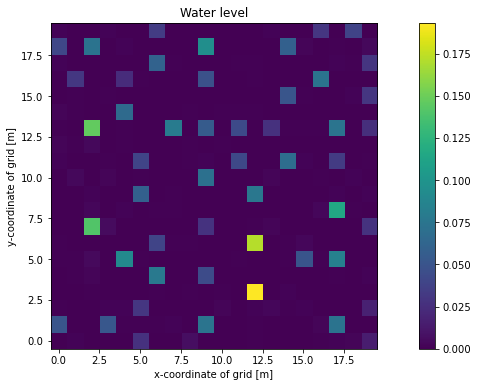

In [105]:
level_grid = sim.grid('level')

plt.figure(figsize=(15, 6))
plt.title('Water level')
plt.xlabel('x-coordinate of grid [m]')
plt.ylabel('y-coordinate of grid [m]')
plt.imshow(sim.water_grid, origin='lower')
plt.colorbar()
plt.show()

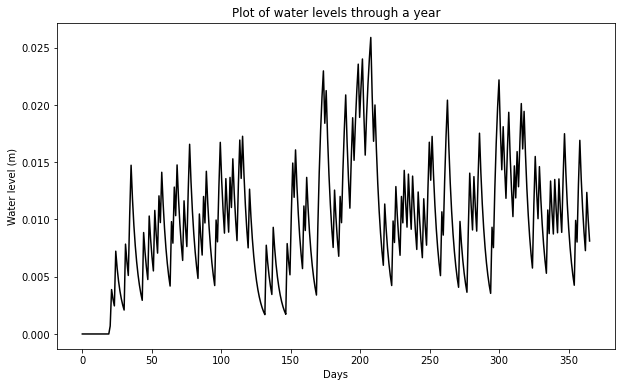

In [106]:
days = np.linspace(0, len(avg_water), len(avg_water))

plt.figure(figsize = (10, 6))
plt.plot(days, avg_water, color = 'black')
plt.xlabel('Days')
plt.ylabel('Water level (m)')
plt.title('Plot of water levels through a year')
plt.show()

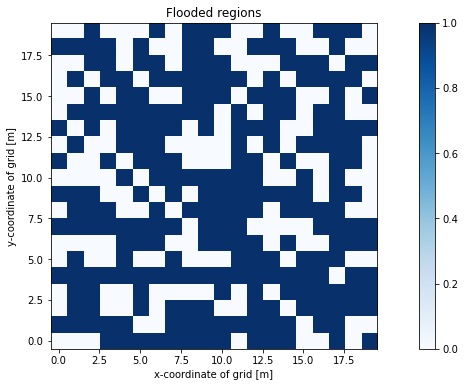

In [107]:
level_grid = sim.grid('flood')

plt.figure(figsize=(15, 6))
plt.title('Flooded regions')
plt.xlabel('x-coordinate of grid [m]')
plt.ylabel('y-coordinate of grid [m]')
plt.imshow(level_grid, origin='lower', cmap = "Blues")
plt.colorbar()
plt.show()

In [108]:
sim.percolation()

False

<IPython.core.display.Javascript object>


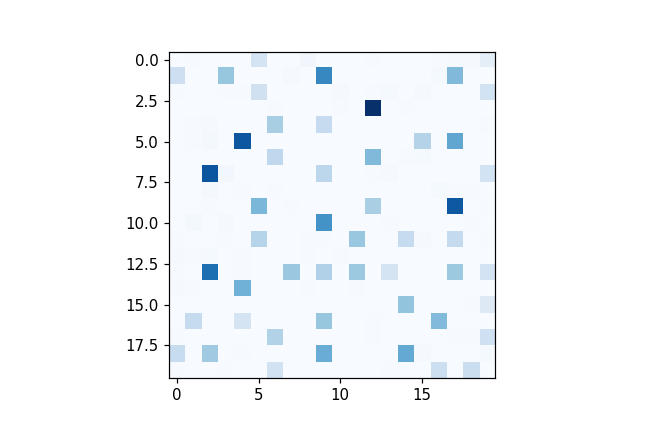

In [34]:
%matplotlib inline
%matplotlib notebook
from matplotlib import pyplot as plt
from matplotlib import animation
import numpy as np

#https://stackoverflow.com/questions/68432834/how-does-one-animate-a-2d-grid-using-matplotlib    
def frame(t):
    """
    Update the grid and return a plot of the earlier grid.
    t (time) is not used, but necessary to be able to pass
    this function to matplotlib.animation.FuncAnimation.
    """
    plt.cla()
    image = plt.imshow(sim.water_grid, cmap='Blues')
    sim.update()
    return image

fig, ax = plt.subplots()
ani = animation.FuncAnimation(fig, frame)
plt.show()

### Empirical Analysis : with a 1000 trials

In [124]:
prob_of_rain = 114/365
avg_rain = 0.00956
recovery_rate = 0.8
trials = 1000

flood_prop = []
percolation = []
avg_water_level = []  #water on ground that can be observed
avg_total_level = [] #total water level, inlcuding underground level 

for i in range(trials):
    sim = Simulation(elev, prob_of_rain, recovery_rate, avg_rain)
    water = []
    flood = []
    total = []
    for i in range(365):
        sim.update()
        water.append(np.mean(sim.water_grid))
        flood.append(np.mean(sim.grid('flood')))
        total.append(np.mean(sim.grid('level')))
    percolation.append(sim.percolation())
    avg_water_level.append(np.mean(water))
    flood_prop.append(np.mean(flood))
    avg_total_level.append(np.mean(total))
    

In [125]:
print(f"We observe percolation {(sum(percolation)/trials)*100} % of the time")

We observe percolation 54.1 % of the time


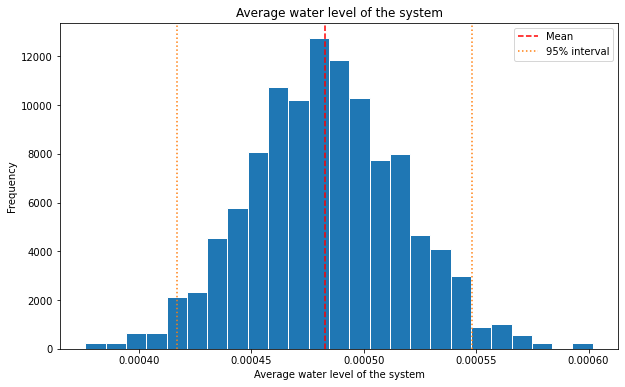

0.0004829851659640817 0.0004167855132548186 0.0005481974523496318


In [193]:
#average water levels

plt.figure(figsize = (10, 6))
plt.hist(avg_water_level, bins = 25, edgecolor = 'white', color = 'C0', density = True)
plt.axvline(np.mean(avg_water_level), color = 'red', ls = '--', label = 'Mean')
plt.axvline(np.quantile(avg_water_level, 0.025), ls = ':', color = 'C1', label = '95% interval')
plt.axvline(np.quantile(avg_water_level, 0.975), ls = ':', color = 'C1')
plt.xlabel('Average water level of the system')
plt.ylabel('Frequency')
plt.title('Average water level of the system')
plt.legend()
plt.show()

print(np.mean(avg_water_level), np.quantile(avg_water_level, 0.025), np.quantile(avg_water_level, 0.975))


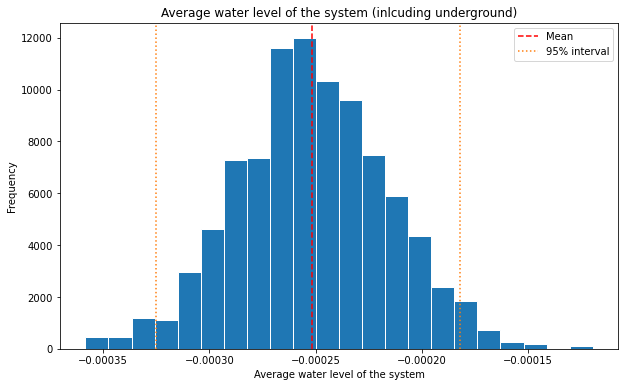

-0.00025157993603980923 -0.00032495337579863457 -0.00018194284293363862


In [194]:

plt.figure(figsize = (10, 6))
plt.hist(avg_total_level, bins = 22, edgecolor = 'white', color = 'C0', density = True)
plt.axvline(np.mean(avg_total_level), color = 'red', ls = '--', label = 'Mean')
plt.axvline(np.quantile(avg_total_level, 0.025), ls = ':', color = 'C1', label = '95% interval')
plt.axvline(np.quantile(avg_total_level, 0.975), ls = ':', color = 'C1')
plt.xlabel('Average water level of the system')
plt.ylabel('Frequency')
plt.title('Average water level of the system (inlcuding underground)')
plt.legend()
plt.show()

print(np.mean(avg_total_level), np.quantile(avg_total_level, 0.025), np.quantile(avg_total_level, 0.975))


No handles with labels found to put in legend.


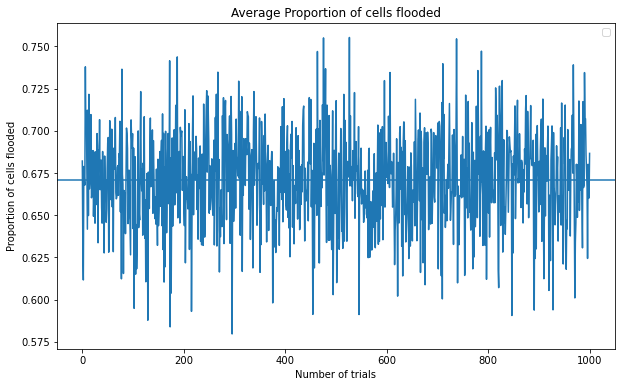

In [147]:
#proportion of cells flooded by the end of the year 

x = np.linspace(0, trials, trials)
plt.figure(figsize = (10, 6))
#plt.hist(flood_prop, bins = 20, edgecolor = 'white', color = 'C0', density = True)
plt.plot(x, flood_prop)
#plt.axvline(np.mean(flood_prop), color = 'red', ls = '--', label = 'Mean')
#plt.axvline(np.quantile(flood_prop, 0.025), ls = ':', color = 'C1', label = '95% interval')
#plt.axvline(np.quantile(flood_prop, 0.975), ls = ':', color = 'C1')
plt.axhline(np.mean(flood_prop))
plt.xlabel('Number of trials')
plt.ylabel('Proportion of cells flooded')
plt.title('Average Proportion of cells flooded')
plt.legend()
plt.show()

In [114]:
prob_of_rain = 114/365
avg_rain = 0.00956
recovery_rate = np.linspace(0.1, 1, 100)

flood_prop = []
percolation = []
avg_water_level = []

for r in recovery_rate:
    sim = Simulation(elev, prob_of_rain, r, avg_rain)
    water = []
    flood = []
    for i in range(365):
        sim.update()
        water.append(np.mean(sim.water_grid))
        flood.append(np.mean(sim.grid('flood')))
    percolation.append(sim.percolation())
    avg_water_level.append(np.mean(water))
    flood_prop.append(np.mean(flood))
    

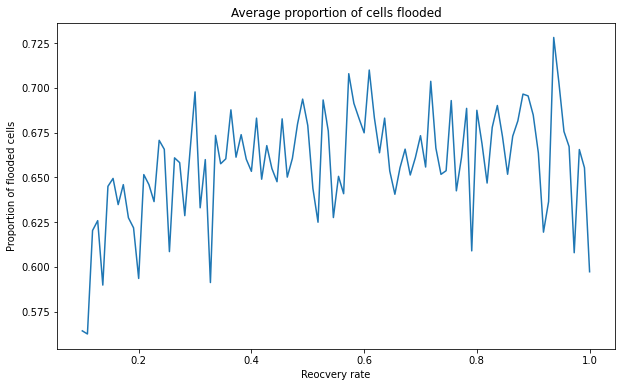

In [115]:

plt.figure(figsize = (10, 6))
plt.plot(recovery_rate, flood_prop, color = 'C0')
plt.xlabel('Reocvery rate')
plt.ylabel('Proportion of flooded cells')
plt.title('Average proportion of cells flooded')
plt.show()

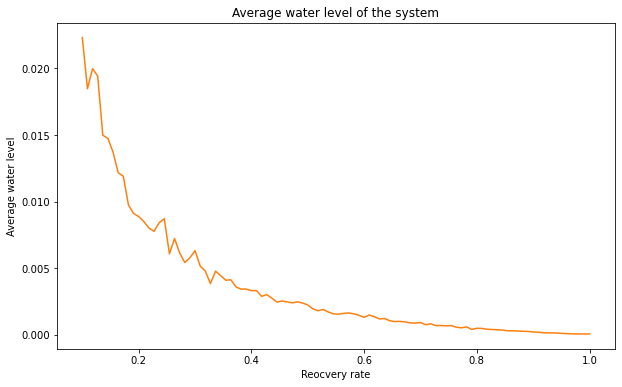

In [116]:
plt.figure(figsize = (10, 6))
plt.plot(recovery_rate, avg_water_level, color = 'C1')
plt.xlabel('Reocvery rate')
plt.ylabel('Average water level')
plt.title('Average water level of the system')
plt.show()

### Ideas 

Empirical analysis
- a simulation result 
- density plots 
- cobweb plots
- inflection point plot

Theoretical analysis
- mean-field approximation 
- percolation calculation 


In [145]:
%matplotlib inline
%matplotlib notebook
from matplotlib import pyplot as plt
from matplotlib import animation
import numpy as np

In [ ]:
#code for simulation 

import matplotlib
import numpy as np
%matplotlib inline
import pylab


the following code has been adapted from Stackoverflow 
#https://stackoverflow.com/questions/68432834/how-does-one-animate-a-2d-grid-using-matplotlib    
def frame(t):
    """
    Update the grid and return a plot of the earlier grid.
    t (time) is not used, but necessary to be able to pass
    this function to matplotlib.animation.FuncAnimation.
    """
    plt.cla()
    image = plt.imshow(config, cmap='gnuplot')
    update()
    return image

fig, ax = plt.subplots()
ani = animation.FuncAnimation(fig, frame)
plt.show()


<ipython-input-192-5bf3e41f1483>:10: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
  t = linspace(a, b, N)


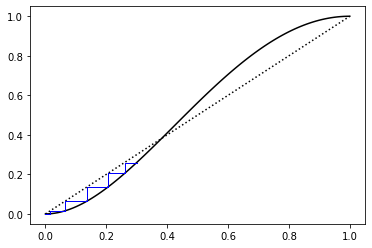

In [192]:
#cobweb plot

import matplotlib.pyplot as plt

def f(x):
    return  x**4 + 4*x**3*(1-x) + 4*x**2*(1-x)**2

def cobweb(f, x0, N, a=0, b=1):
    # plot the function being iterated
    t = linspace(a, b, N)
    plt.plot(t, f(t), 'k')

    # plot the dotted line y = x
    plt.plot(t, t, "k:")

    # plot the iterates
    x, y = x0, f(x0)
    for _ in range(N):
        fy = f(y)        
        plt.plot([x, y], [y,  y], 'b', linewidth=1)
        plt.plot([y, y], [y, fy], 'b', linewidth=1)
        x, y = y, fy

    #plt.axes().set_aspect(1) 
    plt.show()
    plt.close()
        
cobweb(f, 0.3, 100)

In [ ]:
#density plots

import matplotlib.pyplot as plt

p_values = np.linspace(0.1, 0.5, 50)
data = []
for p in p_values:
    initialize(p = p)
    for i in range(20):
        update()
    data.append(density[-1])

plt.figure()
plt.plot(p_values, data)
plt.title('Density plot of different initial p values')
plt.xlabel('p values')
plt.ylabel('Density')
plt.axvline(x = 0.37, color = 'red', linestyle = '--')
plt.show()

In [ ]:
#meanfield 

from sympy.abc import p, k
from sympy.stats import Binomial
from sympy import summation 
from sympy import binomial

a = (1-p)* binomial(8, 3) * (p**3) * ((1-p)**(8-5))
b = summation(binomial(8,k) * (p**k) * ((1-p)**(8-k)), (k, 2, 3)) 
a+b
